<a href="https://colab.research.google.com/github/JonathanLehner/Colab-collection/blob/master/hand_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Python 3 with GPU
# ensure the code is as deterministic as possible and allow running it with multiple seeds
# https://pytorch.org/docs/stable/notes/randomness.html
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Generates hands with different parameters with Mano (https://github.com/hassony2/manopth)
and uses Pyrender (https://github.com/mmatl/pyrender) to render these with background and hand textures.

Use pandas to write the labels in a csv file.

In [32]:
!git clone https://github.com/hassony2/manopth

fatal: destination path 'manopth' already exists and is not an empty directory.


In [33]:
% cd /content/manopth

/content/manopth


In [34]:
# install conda
# see https://facebookresearch.github.io/TensorComprehensions/installation_colab_research.html
!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
#!conda install -q -y --prefix /usr/local -c pytorch
!conda env create -f environment.yml

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')


--2019-05-14 17:08:55--  https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
installing: python-3.6.4-hc3d631a_1 ...
Python 3.6.4 :: Anaconda, Inc.
installing: ca-certificates-2017.08.26-h1d4fec5_0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: intel-openmp-2018.0.0-hc7b2577_8 ...
installing: libgcc-ng-7.2.0-h7cc24e2_2 ...
installing: libgfortran-ng-7.2.0-h9f7466a_2 ...
installing: libstdcxx-ng-7.2.0-h7a57d05_2 ...
installing: bzip2-1.0.6-h9a117a8_4 ...
installing: expat-2.2.5-he0dffb1_0 ...
installing: gmp-6.1.2-h6c8ec71_1 ...
installing: graphite2-1.3.10-hf63cedd_1 ...
installing: icu-58.2-h9c2bf20_1 ...
installing: jbig

In [35]:
!nvcc --version
!conda install pytorch torchvision cudatoolkit=10.0 -c pytorch


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.6.14

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [0]:
!wget https://github.com/JonathanLehner/Colab-collection/releases/download/MANO/mano_v1_2.zip
!unzip mano_v1_2.zip
!mv /content/manopth/mano_v1_2/models /content/manopth/mano/models 

In [52]:
#!source activate manopth
!pip install git+https://github.com/hassony2/chumpy.git
!pip install opencv-python
!pip install tqdm

  Cloning https://github.com/hassony2/chumpy.git to /tmp/pip-xomi9s47-build
    100% |████████████████████████████████| 51kB 4.4MB/s 


In [0]:
%cd /content/manopth/
#!pip3 install --upgrade setuptools
#!apt-get install python3.7-dev libmysqlclient-dev
#!pip3 install .
#sudo apt-get install libmysqlclient-dev

!python setup.py install

In [0]:
# !conda update -n base conda
!conda list pytorch # must be version 1.1

/content/manopth


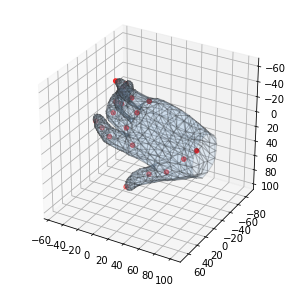

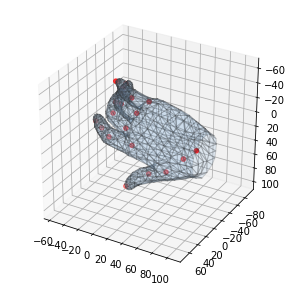

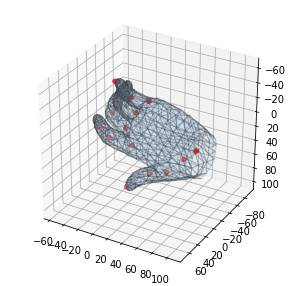

In [53]:
%cd /content/manopth/

# have to inline /content/manopth/examples/manopth_mindemo.py
import torch
from manopth.manolayer import ManoLayer
from manopth import demo

# create 100 hands
batch_size = 100

# Select number of principal components for pose space
ncomps = 6

# Initialize MANO layer
mano_layer = ManoLayer(
    mano_root='mano/models', use_pca=True, ncomps=ncomps, flat_hand_mean=False)

# Generate random shape parameters
random_shape = torch.rand(batch_size, 10)
# Generate random pose parameters, including 3 values for global axis-angle rotation
random_pose = torch.ones(batch_size, ncomps + 3) 

# cut the first 3 values since we do them in pyrender

for random_tensor in random_pose: # should do this more efficiently
  random_tensor[0] = 0
  random_tensor[1] = 0
  random_tensor[2] = 0
  # print(random_tensor)

# from https://github.com/hassony2/manopth/blob/master/manopth/demo.py
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from manopth import demo

def display_hand(hand_info, mano_faces=None, ax=None, alpha=0.2, batch_idx=0, show=True):
    """
    Displays hand batch_idx in batch of hand_info, hand_info as returned by
    generate_random_hand
    """

    if ax is None:
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, projection='3d')
        
    verts, joints = hand_info['verts'][batch_idx], hand_info['joints'][
        batch_idx]
    
    if mano_faces is None:
        ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], alpha=0.1)
    else:
        mpl_mesh = Poly3DCollection(verts[mano_faces], alpha=alpha)
        face_color = (141 / 255, 184 / 255, 226 / 255)
        edge_color = (50 / 255, 50 / 255, 50 / 255)
        mpl_mesh.set_edgecolor(edge_color)
        mpl_mesh.set_facecolor(face_color)
        ax.add_collection3d(mpl_mesh)
        
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], color='r')
        
    demo.cam_equal_aspect_3d(ax, verts.numpy())
    if show:
        plt.show()

# Forward pass through MANO layer
hand_verts, hand_joints = mano_layer(random_pose, random_shape)
mano_faces=mano_layer.th_faces

display_hand({'verts': hand_verts,'joints': hand_joints},mano_faces=mano_faces, batch_idx=0)
display_hand({'verts': hand_verts,'joints': hand_joints},mano_faces=mano_faces, batch_idx=1)
display_hand({'verts': hand_verts,'joints': hand_joints},mano_faces=mano_faces, batch_idx=2)



In [54]:
# get mesh of first hand in batch
verts, joints = hand_verts[0], hand_joints[0]
mpl_mesh = Poly3DCollection(verts[mano_faces], alpha=0.2)
print(mano_faces)
print(verts)

%cd /content/
!mkdir /content/hands
!pwd
%cd /content/

num_vertices = len(verts)
num_faces = len(mano_faces)

for num_hand, verts in enumerate(hand_verts):
  print("hand {0}".format(num_hand))
  # https://blender.stackexchange.com/questions/32468/how-to-write-a-simple-wavefront-obj-exporter-in-python
  with open("/content/hands/hand_mesh_{0}.obj".format(num_hand), 'w') as f:
      f.write("####\n")
      f.write("# Object hand_mesh.obj\n")
      f.write("#\n")
      f.write("# Vertices: {0}\n".format(num_vertices))
      f.write("# Faces: {0}\n".format(num_faces))
      f.write("#\n")
      f.write("####\n")
      # try to use vertex colors
      # f.write("mtllib ./hand_mesh.obj.mtl\n")
      f.write("# OBJ file\n")
      for v in verts:
          f.write("v %.4f %.4f %.4f\n" % (v[0], v[1], v[2]))
      for p in mano_faces:
          f.write("f")
          for i in p:
              f.write(" %d" % (i + 1))
          f.write("\n")


tensor([[  1,   2,   0],
        [  0,   2,   3],
        [  4,   5,   7],
        ...,
        [240, 266,   9],
        [  9, 266,   8],
        [  8, 266,  10]])
tensor([[ 43.1418, -10.8154,  22.3248],
        [ 53.1591, -13.2658,  22.9000],
        [ 46.2919, -14.7491,  31.4756],
        ...,
        [ 36.7189, -13.2243, -23.3902],
        [ 27.3910, -10.1913, -25.1908],
        [ 52.4337, -12.7642, -12.1863]])
/content
mkdir: cannot create directory ‘/content/hands’: File exists
/content
/content
hand 0
hand 1
hand 2
hand 3
hand 4
hand 5
hand 6
hand 7
hand 8
hand 9
hand 10
hand 11
hand 12
hand 13
hand 14
hand 15
hand 16
hand 17
hand 18
hand 19
hand 20
hand 21
hand 22
hand 23
hand 24
hand 25
hand 26
hand 27
hand 28
hand 29
hand 30
hand 31
hand 32
hand 33
hand 34
hand 35
hand 36
hand 37
hand 38
hand 39
hand 40
hand 41
hand 42
hand 43
hand 44
hand 45
hand 46
hand 47
hand 48
hand 49
hand 50
hand 51
hand 52
hand 53
hand 54
hand 55
hand 56
hand 57
hand 58
hand 59
hand 60
hand 61
hand 62


In [0]:
# add the missing vertex to close the hand
# use https://colab.research.google.com/drive/18sXTBHGsYmOOD-D_-MFDe0Iyu-RbqrLP#scrollTo=yewT496H4pEd